In [1]:
import glob
import os
import pickle

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

from generators import ImageGenerator
from utils import plot_accuracy_loss

In [2]:
# set path to data
primary_path = '../webvision-2020-public/classification/data/'

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [4]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


In [5]:
# change batch size
# remove sample_frac
training_data = ImageGenerator(primary_path + 'train/',
                               64, (300, 300), sample_frac = 0.1)

validation_data = ImageGenerator(primary_path + 'validation/',
                                 64, (300, 300))

Found 1497365 instances belonging to 5000 classes
Found 294099 instances belonging to 5000 classes


In [35]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./checkpoints/cp-{epoch:04d}.ckpt',
    save_weights_only=True,
    monitor='loss',
    mode='max')

In [36]:
with strategy.scope():
    pre_trained_model = InceptionV3(input_shape = (300, 300, 3), 
                                    include_top = False)

    # find the last module before opening for training
    for i, layer in enumerate(pre_trained_model.layers):
        if layer.name == 'mixed5':
            last_trainable_layer = i
            break
    last_trainable_layer += 1
    
    print("Unfreezing from " 
          + pre_trained_model.layers[last_trainable_layer-1].name)
    
    # lock the early layers
    for layer in pre_trained_model.layers[:last_trainable_layer]:
        layer.trainable = False

    # unlock the later layers
    for layer in pre_trained_model.layers[last_trainable_layer:]:
        layer.trainable = True
        
    # use mixed10 as the last layer from inception3
    last_layer = pre_trained_model.get_layer('mixed10')
    print('last layer output shape: ', last_layer.output_shape)
    last_output = last_layer.output

    # Flatten the output layer to 1 dimension
    x = tf.keras.layers.GlobalAveragePooling2D()(last_output)

    #x = Dense(2048, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    #output = Dense(len(data.classes),activation='softmax',name='output')(x)

    output = tf.keras.layers.Dense(5000, activation='softmax', name='output')(x)

    inception_model = Model(inputs=[pre_trained_model.input], outputs=[output])
    inception_model.summary()

    inception_model.compile(optimizer='adam', 
                            loss='sparse_categorical_crossentropy', 
                            metrics=['accuracy', 'sparse_top_k_categorical_accuracy'])

Unfreezing from mixed5
last layer output shape:  (None, 8, 8, 2048)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 149, 149, 32) 96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 149, 149, 32) 0           batch_normalization_376[0][0]    
________________________

In [38]:
image_hist = inception_model.fit(training_data,
                                 epochs = 3,
                                 validation_data = validation_data,
                                 callbacks=[model_checkpoint_callback],
                                 workers = 4
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 23396 steps, validate for 4595 steps
Epoch 1/3
INFO:tensorflow:batch_all_reduce: 90 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
    5/23396 [..............................] - ETA: 14:38:27 - loss: 8.6056 - accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00

/home/stuart/anaconda3/envs/tf2/lib/python3.6/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


23396/23396 [==============================] - 9133s 390ms/step - loss: 8.9622 - accuracy: 0.0013 - sparse_top_k_categorical_accuracy: 0.0051 - val_loss: 10.1182 - val_accuracy: 3.1964e-04 - val_sparse_top_k_categorical_accuracy: 0.0010
Epoch 2/3
23396/23396 [==============================] - 9057s 387ms/step - loss: 7.5630 - accuracy: 0.0088 - sparse_top_k_categorical_accuracy: 0.0324 - val_loss: 11.6640 - val_accuracy: 2.0063e-04 - val_sparse_top_k_categorical_accuracy: 0.0011
Epoch 3/3
23396/23396 [==============================] - 9021s 386ms/step - loss: 6.6120 - accuracy: 0.0345 - sparse_top_k_categorical_accuracy: 0.1060 - val_loss: 12.8167 - val_accuracy: 2.1083e-04 - val_sparse_top_k_categorical_accuracy: 0.0010


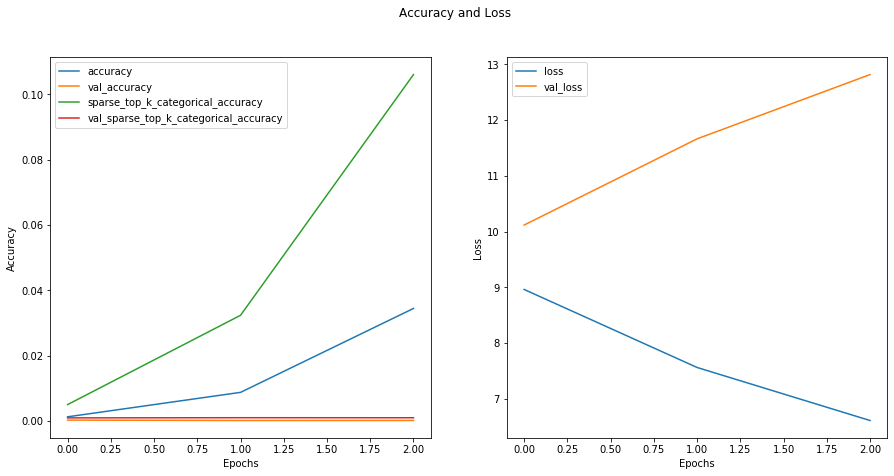

In [43]:
import matplotlib.pyplot as plt

plot_accuracy_loss(image_hist,
                   ['accuracy','val_accuracy',
                    'sparse_top_k_categorical_accuracy','val_sparse_top_k_categorical_accuracy'],
                   ['loss','val_loss'])

**Pickle the history and save the model**

In [ ]:
with open('image_hist.pickle', 'wb') as f:
    pickle.dump(image_hist, f)